## 1. Compare the Tree-like algorithms: Tree, Random Forest, AdaBoost 비교

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_digits   #digits은 해상도 수치
from scipy.ndimage.interpolation import rotate
warnings.filterwarnings(action='ignore')                  # Turn off the warnings.
%matplotlib inline

### 1.1. Read in data and explore:

In [2]:
data = load_digits()  #digits은 해상도 수치

In [3]:
print(data['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
#설명변수
X = data['data']
X.shape

(1797, 64)

In [5]:
#반응변수
Y = data['target']
Y.shape

(1797,)

In [6]:
# Define a visualization function.
def show_data(X, Y, n, angle=0):
    print(Y[n])
    image_matrix = X[n,:].reshape((8,8))                                         #1차원에서 2차원 행렬로 변환
    image_matrix = rotate(image_matrix, angle, cval=0.01, reshape=False)        # Rotate if wanted.       
    plt.imshow(image_matrix, cmap='Greys',interpolation='None')
    plt.show()


5


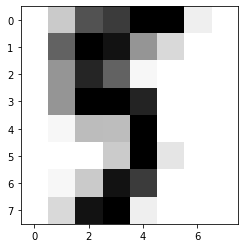

9


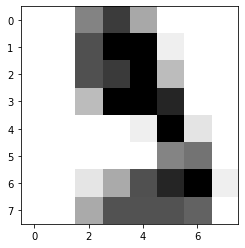

1


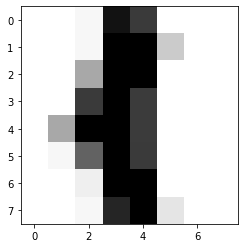

In [7]:
for i in [15,29,99]:  #해상도 수치
    show_data(X,Y,i)

### 1.2. Data pre-processing: 데이터 전처리

In [8]:
# Min-Max scaling 
X_min = X.min()
X_max = X.max()
X_range = X_max - X_min
X = (X - X_min)/X_range   #x변수가 0~1수치가 되도록하는 공식(0~1사이로 정규화)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

### 1.3. Classification with Tree (optimized hyperparameters):

NOTE: 시간 상 일부 하이퍼 파라미터만 최적화

In [10]:
depth_grid = np.arange(1,21)                 #depth로 리스트 만들어 grid
min_samples_leaf_grid = np.arange(2,31,2)    #min_samples_leaf로 리스트 만들어 grid
max_leaf_nodes_grid = np.arange(2,51,2)      #max_leaf_nodes로 리스트 만들어 grid
parameters = {'max_depth':depth_grid, 'min_samples_leaf':min_samples_leaf_grid, 'max_leaf_nodes':max_leaf_nodes_grid}  #parameters 딕셔너리

In [11]:
gridCV = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, n_jobs = -1) #GridSearchCV로 최적의 하이퍼 파라미터 조합 만듬

gridCV.fit(X_train, Y_train)

best_depth = gridCV.best_params_['max_depth']                     #딕셔너리에서 max_depth의 베스트 파라미터 뽑음
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']   #딕셔너리에서 min_samples_leaf의 베스트 파라미터 뽑음
best_max_leaf_nodes = gridCV.best_params_['max_leaf_nodes']       #딕셔너리에서 max_leaf_nodes의 베스트 파라미터 뽑음

In [12]:
print("Tree best max_depth : " + str(best_depth))
print("Tree best min_samples_leaf : " + str(best_min_samples_leaf))
print("Tree best max_leaf_nodes : " + str(best_max_leaf_nodes))

Tree best max_depth : 18
Tree best min_samples_leaf : 4
Tree best max_leaf_nodes : 46


In [13]:
DTC_best = DecisionTreeClassifier(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,max_leaf_nodes=best_max_leaf_nodes)
DTC_best.fit(X_train, Y_train)
Y_pred = DTC_best.predict(X_test)
print( "Tree best accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Tree best accuracy : 0.852


### 1.4. Classification with Random Forest (optimized hyperparameters):

NOTE: 시간 상 일부 하이퍼 파라미터만 최적화

In [14]:
n_estimators_grid = np.arange(20, 50,2)
depth_grid = np.arange(1, 10)
min_samples_leaf_grid = np.arange(10,21,2)
parameters = {'n_estimators': n_estimators_grid, 'max_depth': depth_grid, 'min_samples_leaf':min_samples_leaf_grid}

gridCV = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=10, n_jobs=-1)

gridCV.fit(X_train, Y_train)

best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']

In [15]:
print("Random Forest best n_estimator : " + str(best_n_estim))
print("Random Forest best max_depth : " + str(best_depth))
print("Random Forest best min_samples_leaf : " + str(best_min_samples_leaf))

Random Forest best n_estimator : 32
Random Forest best max_depth : 8
Random Forest best min_samples_leaf : 10


In [16]:
RF_best = RandomForestClassifier(n_estimators=30,max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,random_state=123)
RF_best.fit(X_train, Y_train)
Y_pred = RF_best.predict(X_test)
print( "Random Forest best accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Random Forest best accuracy : 0.935


### 1.5. Classification with AdaBoost (optimized hyperparameters):

NOTE: 시간 상 일부 하이퍼 파라미터만 최적화

In [17]:
my_max_depth = 9                                               # Fixed.
my_learn_rate = 0.01                                           # Fixed.
n_estimators_grid = np.arange(50, 81, 2)
parameters = {'n_estimators': n_estimators_grid}

AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=my_max_depth), learning_rate=my_learn_rate)      # Instantiate an estimator.
gridCV = GridSearchCV(AB, param_grid=parameters, cv=10, n_jobs = -1)

gridCV.fit(X_train, Y_train)

best_n_estim = gridCV.best_params_['n_estimators']

In [18]:
print("AdaBoost best n estimator : " + str(best_n_estim))

AdaBoost best n estimator : 62


In [19]:
AB_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=my_max_depth),n_estimators=best_n_estim,learning_rate=my_learn_rate,random_state=123)
AB_best.fit(X_train, Y_train)
Y_pred = AB_best.predict(X_test)
print( "AdaBoost best accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

AdaBoost best accuracy : 0.931


랜덤포레스트가 성능이 가장 좋음<br>
셋 중에 랜덤포레스트 추천!!
